# MLP Trained on the Fashion-MNIST Dataset Using Tensorflow

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, Rescaling
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.optimizers.legacy import SGD
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy

import wandb
from wandb.keras import WandbCallback

from matplotlib import pyplot as plt

from pprint import pprint

## Login to Wandb

In [2]:
wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Load Fashion-MNIST

In [3]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [4]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


## Plot some examples

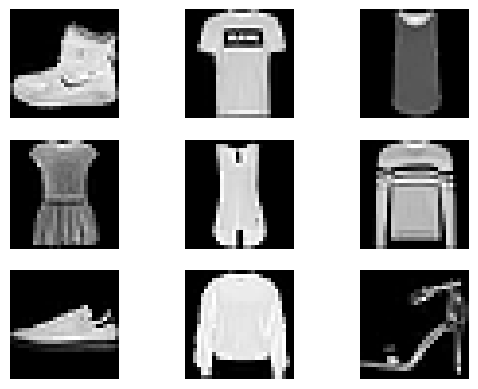

In [5]:
i = 0

for picture in x_train[:9]:
    plt.subplot(3, 3, i+1)
    plt.imshow(picture, cmap='gray')
    plt.axis('off')
    i = i + 1

plt.show()

## Define function for MLP creation

In [6]:
def create_model(config):
    model = Sequential([
        Rescaling(scale=1./255, input_shape=(28, 28)),
        Flatten(),
        
        Dense(config.dense_1, activation='relu'),
        Dense(config.dense_2, activation='relu'),
        Dense(config.dense_3, activation='relu'),
        Dense(config.dense_4, activation='relu'),

        Dense(10, activation='softmax'),
    ])

    return model

## Define function for model compilation

In [7]:
def compile_model(model, config):
    model.compile(
        optimizer=SGD(learning_rate=config.learning_rate, momentum=config.momentum),
        loss=SparseCategoricalCrossentropy(),
        metrics=[SparseCategoricalAccuracy()]
    )

## Define function for model training

In [8]:
def train_model(model, config, x_train, y_train):
    history = model.fit(
        x_train,
        y_train,
        epochs=config.epochs,
        validation_split=0.2,
        batch_size=config.batch_size,
        shuffle=True,
        callbacks=[
            WandbCallback()
        ]
    )

    return history

## Define sweep agent function

In [9]:
def sweep_train():
    default_config = {
        'dense_1': 512,
        'dense_2': 256,
        'dense_3': 256,
        'dense_4': 64,
        'learning_rate': 0.001,
        'momentum': 0.0,
        'epochs': 200,
        'batch_size': 128,
    }

    wandb.init(config=default_config)

    config = wandb.config

    mlp = create_model(config)
    mlp.summary()
    compile_model(mlp, config)
    _ = train_model(mlp, config, x_train, y_train)

## Configure Wandb Sweep for hyperparameter tuning

In [10]:
sweep_config = {
    'method': 'bayes',
    'metric': {
        'name': 'val_loss',
        'goal': 'minimize'
    },
    'early_terminate':{
        'type': 'hyperband',
        'min_iter': 2
    },
    'parameters': {
        'batch_size': {
            'values': [16, 32, 64, 128, 256]
        },
        'epochs': {
            'min': 20,
            'max': 200
        },
        'learning_rate': {
            'min': 0.0001,
            'max': 0.1
        },
        'momentum': {
            'min': 0.0,
            'max': 0.9
        },
        'dense_1': {
            'min': 256,
            'max': 512
        },
        'dense_2': {
            'min': 128,
            'max': 256
        },
        'dense_3': {
            'min': 128,
            'max': 256
        },
        'dense_4': {
            'min': 32,
            'max': 128
        }
    }
}

pprint(sweep_config)

sweep_id = wandb.sweep(sweep_config, project='tf_mlp')

{'early_terminate': {'min_iter': 2, 'type': 'hyperband'},
 'method': 'bayes',
 'metric': {'goal': 'minimize', 'name': 'val_loss'},
 'parameters': {'batch_size': {'values': [16, 32, 64, 128, 256]},
                'dense_1': {'max': 512, 'min': 256},
                'dense_2': {'max': 256, 'min': 128},
                'dense_3': {'max': 256, 'min': 128},
                'dense_4': {'max': 128, 'min': 32},
                'epochs': {'max': 200, 'min': 20},
                'learning_rate': {'max': 0.1, 'min': 0.0001},
                'momentum': {'max': 0.9, 'min': 0.0}}}
Create sweep with ID: 3ca45van
Sweep URL: https://wandb.ai/nsiete23/tf_mlp/sweeps/3ca45van


## Run sweep

In [11]:
wandb.agent(sweep_id, function=sweep_train, count=50)

wandb: Agent Starting Run: byv3ce5q with config:
wandb: 	batch_size: 128
wandb: 	dense_1: 290
wandb: 	dense_2: 130
wandb: 	dense_3: 151
wandb: 	dense_4: 117
wandb: 	epochs: 181
wandb: 	learning_rate: 0.02369525003368836
wandb: 	momentum: 0.4164692634706077
wandb: Currently logged in as: v-modroczky (nsiete23). Use `wandb login --relogin` to force relogin


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 290)               227650    
                                                                 
 dense_1 (Dense)             (None, 130)               37830     
                                                                 
 dense_2 (Dense)             (None, 151)               19781     
                                                                 
 dense_3 (Dense)             (None, 117)               17784     
                                                                 
 dense_4 (Dense)             (None, 10)                1

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/181
375/375 [==============================] - 4s 5ms/step - loss: 0.8376 - sparse_categorical_accuracy: 0.7135 - val_loss: 0.5314 - val_sparse_categorical_accuracy: 0.8152 - _timestamp: 1677664017.0000 - _runtime: 25.0000
Epoch 2/181
375/375 [==============================] - 2s 4ms/step - loss: 0.5013 - sparse_categorical_accuracy: 0.8210 - val_loss: 0.4652 - val_sparse_categorical_accuracy: 0.8365 - _timestamp: 1677664019.0000 - _runtime: 27.0000
Epoch 3/181
375/375 [==============================] - 2s 4ms/step - loss: 0.4395 - sparse_categorical_accuracy: 0.8440 - val_loss: 0.4245 - val_sparse_categorical_accuracy: 0.8472 - _timestamp: 1677664020.0000 - _runtime: 28.0000
Epoch 4/181
375/375 [==============================] - 2s 4ms/step - loss: 0.4087 - sparse_categorical_accuracy: 0.8541 - val_loss: 0.4368 - val_sparse_categorical_accuracy: 0.8407 - _timestamp: 1677664022.0000 - _runtime: 30.0000
Epoch 5/181
375/375 [==============================] - 1s 4ms/step - loss: 0

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▆▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▃▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█▇███████████████
val_loss,▃▂▁▁▁▁▂▁▁▁▂▂▂▂▂▃▃▄▄▄▄▄▅▄▅▆▆▆▆▆▆▆▆▇▇▇████
val_sparse_categorical_accuracy,▁▄▅▅▇▇▅▇▇▇▇▇▇▇▇▇█▇▆▇▇▇▇▇▇▇▇▇▇▇▇█████████
GFLOPS,0.0003
best_epoch,25
best_val_loss,0.3121
epoch,180
loss,0.00028
sparse_categorical_accuracy,1.0


wandb: Agent Starting Run: d93rz8f3 with config:
wandb: 	batch_size: 128
wandb: 	dense_1: 425
wandb: 	dense_2: 163
wandb: 	dense_3: 182
wandb: 	dense_4: 33
wandb: 	epochs: 53
wandb: 	learning_rate: 0.056363894502332
wandb: 	momentum: 0.3605320397564238


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 425)               333625    
                                                                 
 dense_1 (Dense)             (None, 163)               69438     
                                                                 
 dense_2 (Dense)             (None, 182)               29848     
                                                                 
 dense_3 (Dense)             (None, 33)                6039      
                                                                 
 dense_4 (Dense)             (None, 10)                3

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▅▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████
val_loss,█▆▄▄▃▃▂▃▃▂▂▁▂▂▃▂▂▂▃▂▃▄▃▂▃▅▄▆▃▄▅▅▅▅▅▆▅▇▆▇
val_sparse_categorical_accuracy,▁▃▅▅▅▆▆▅▆▇▆▇▆▇▇▇▇█▇█▇▇▇█▇▇▇▇█▇▇▇███▇████
GFLOPS,0.00044
best_epoch,14
best_val_loss,0.29559
epoch,52
loss,0.07627
sparse_categorical_accuracy,0.97185


wandb: Agent Starting Run: xt2xf05p with config:
wandb: 	batch_size: 32
wandb: 	dense_1: 474
wandb: 	dense_2: 172
wandb: 	dense_3: 192
wandb: 	dense_4: 62
wandb: 	epochs: 34
wandb: 	learning_rate: 0.06876986697858303
wandb: 	momentum: 0.18401378741417684


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 474)               372090    
                                                                 
 dense_1 (Dense)             (None, 172)               81700     
                                                                 
 dense_2 (Dense)             (None, 192)               33216     
                                                                 
 dense_3 (Dense)             (None, 62)                11966     
                                                                 
 dense_4 (Dense)             (None, 10)                6

epoch,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
loss,█▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇████████
val_loss,██▄▃▇▂▂▂▁▃▂▃▂▃▂▃▂▃▃▅▄▃▄▄▄▃▆▅▆▆▅▇▆▇
val_sparse_categorical_accuracy,▂▁▄▅▃▆▆▆▇▆▇▆▇▇█▆▇▇▇▆▇██▇███▇█▇███▇
GFLOPS,0.0005
best_epoch,8
best_val_loss,0.30975
epoch,33
loss,0.1211
sparse_categorical_accuracy,0.95398


wandb: Agent Starting Run: 0ox0m323 with config:
wandb: 	batch_size: 64
wandb: 	dense_1: 473
wandb: 	dense_2: 191
wandb: 	dense_3: 221
wandb: 	dense_4: 35
wandb: 	epochs: 47
wandb: 	learning_rate: 0.07678613282180462
wandb: 	momentum: 0.13460919619146963


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 473)               371305    
                                                                 
 dense_1 (Dense)             (None, 191)               90534     
                                                                 
 dense_2 (Dense)             (None, 221)               42432     
                                                                 
 dense_3 (Dense)             (None, 35)                7770      
                                                                 
 dense_4 (Dense)             (None, 10)                3

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▅▅▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇████████████
val_loss,▇▅▃▄▂▃▁▂▂▂▃▃▁▄▂▁▂▂▂▃▂▃▂▄▃▄▃▄▄▇▅▆▅█▇▆█▆▆█
val_sparse_categorical_accuracy,▁▃▅▅▆▆▇▇▇▆▆▆█▅▇██▇█████▇█▇█▇▇▆▇█▇▅▇▇▇█▇▇
GFLOPS,0.00051
best_epoch,14
best_val_loss,0.29603
epoch,46
loss,0.07993
sparse_categorical_accuracy,0.9685


wandb: Agent Starting Run: xm6ry44u with config:
wandb: 	batch_size: 16
wandb: 	dense_1: 491
wandb: 	dense_2: 151
wandb: 	dense_3: 195
wandb: 	dense_4: 38
wandb: 	epochs: 41
wandb: 	learning_rate: 0.08610229105769715
wandb: 	momentum: 0.7023094886004017


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 491)               385435    
                                                                 
 dense_1 (Dense)             (None, 151)               74292     
                                                                 
 dense_2 (Dense)             (None, 195)               29640     
                                                                 
 dense_3 (Dense)             (None, 38)                7448      
                                                                 
 dense_4 (Dense)             (None, 10)                3

epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
loss,█▄▃▃▂▂▂▂▁▁▁▁▁
sparse_categorical_accuracy,▁▅▆▆▇▇▇▇█████
val_loss,█▃▅▃▅▃▄▄▁▃▁▃▃
val_sparse_categorical_accuracy,▁▅▄▅▃▆▆▇▇▆█▆▇
GFLOPS,0.0005
best_epoch,8
best_val_loss,0.36074
epoch,12
loss,0.33696
sparse_categorical_accuracy,0.88223


wandb: Agent Starting Run: lrxkno4b with config:
wandb: 	batch_size: 64
wandb: 	dense_1: 438
wandb: 	dense_2: 171
wandb: 	dense_3: 225
wandb: 	dense_4: 60
wandb: 	epochs: 63
wandb: 	learning_rate: 0.04522583099945612
wandb: 	momentum: 0.2598000292282161


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 438)               343830    
                                                                 
 dense_1 (Dense)             (None, 171)               75069     
                                                                 
 dense_2 (Dense)             (None, 225)               38700     
                                                                 
 dense_3 (Dense)             (None, 60)                13560     
                                                                 
 dense_4 (Dense)             (None, 10)                6

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
loss,█▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▃▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████
val_loss,▅▄▂▂▂▂▂▂▁▂▂▂▁▂▄▂▂▂▂▃▃▄▃▄▃▄▅▅▄▅▅▅▇█▅▆▆▇▇▇
val_sparse_categorical_accuracy,▁▃▅▅▆▆▆▆▇▇▇▇▇▇▅█▇███▇▇▇███▇▇████▆▆█▇█▇▇█
GFLOPS,0.00047
best_epoch,12
best_val_loss,0.30295
epoch,62
loss,0.05421
sparse_categorical_accuracy,0.97965


wandb: Agent Starting Run: lq98yfu0 with config:
wandb: 	batch_size: 64
wandb: 	dense_1: 425
wandb: 	dense_2: 186
wandb: 	dense_3: 194
wandb: 	dense_4: 44
wandb: 	epochs: 72
wandb: 	learning_rate: 0.07624970116280043
wandb: 	momentum: 0.1196849816818854


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 425)               333625    
                                                                 
 dense_1 (Dense)             (None, 186)               79236     
                                                                 
 dense_2 (Dense)             (None, 194)               36278     
                                                                 
 dense_3 (Dense)             (None, 44)                8580      
                                                                 
 dense_4 (Dense)             (None, 10)                4

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▅▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▃▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
val_loss,▅▄▂▂▂▂▁▂▁▁▁▂▂▁▂▂▂▃▅▃▄▅▄▄▅▄▅▅▅▅▆▅▆▇▇▇▇▇▇█
val_sparse_categorical_accuracy,▁▄▅▆▅▇▇▆▇█▇▇▇████▇▅█▇▇██▇█▇▇██████▇▇████
GFLOPS,0.00046
best_epoch,8
best_val_loss,0.31176
epoch,71
loss,0.04889
sparse_categorical_accuracy,0.98137


wandb: Agent Starting Run: tjtocw2h with config:
wandb: 	batch_size: 64
wandb: 	dense_1: 432
wandb: 	dense_2: 169
wandb: 	dense_3: 185
wandb: 	dense_4: 72
wandb: 	epochs: 33
wandb: 	learning_rate: 0.0897424802942257
wandb: 	momentum: 0.183327711716027


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 432)               339120    
                                                                 
 dense_1 (Dense)             (None, 169)               73177     
                                                                 
 dense_2 (Dense)             (None, 185)               31450     
                                                                 
 dense_3 (Dense)             (None, 72)                13392     
                                                                 
 dense_4 (Dense)             (None, 10)                7

epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
loss,█▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇████████
val_loss,█▆▅▃▃▃▄▂▂▃▂▆▃▂▂▁▃▃▃▂▃▄▄▄▇▄▅▅▄▆▆▅▇
val_sparse_categorical_accuracy,▁▂▃▄▅▅▃▆▆▅▆▃▆▇█▇▆▆▇█▇▆█▇▆▇▇██▇█▇▇
GFLOPS,0.00046
best_epoch,15
best_val_loss,0.31397
epoch,32
loss,0.12124
sparse_categorical_accuracy,0.95254


wandb: Agent Starting Run: fkwta912 with config:
wandb: 	batch_size: 64
wandb: 	dense_1: 508
wandb: 	dense_2: 151
wandb: 	dense_3: 194
wandb: 	dense_4: 75
wandb: 	epochs: 34
wandb: 	learning_rate: 0.07083356580058156
wandb: 	momentum: 0.2338865557825068


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 508)               398780    
                                                                 
 dense_1 (Dense)             (None, 151)               76859     
                                                                 
 dense_2 (Dense)             (None, 194)               29488     
                                                                 
 dense_3 (Dense)             (None, 75)                14625     
                                                                 
 dense_4 (Dense)             (None, 10)                7

epoch,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
loss,█▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇██████████
val_loss,█▆▄▃▃▃▂▂▄▂▂▂▁▂▁▂▄▂▃▂▃▄▃▃▄▃▃▄▄▃▄▄▅▅
val_sparse_categorical_accuracy,▁▃▄▅▅▆▇▇▅▇▇▆▇██▇▆▆▇▇▇▆██▇▇▇███▇▇▇▆
GFLOPS,0.00052
best_epoch,12
best_val_loss,0.29786
epoch,33
loss,0.11563
sparse_categorical_accuracy,0.95531


wandb: Agent Starting Run: gjtma00o with config:
wandb: 	batch_size: 256
wandb: 	dense_1: 478
wandb: 	dense_2: 173
wandb: 	dense_3: 174
wandb: 	dense_4: 77
wandb: 	epochs: 28
wandb: 	learning_rate: 0.0692920770817491
wandb: 	momentum: 0.028221013418845663


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 478)               375230    
                                                                 
 dense_1 (Dense)             (None, 173)               82867     
                                                                 
 dense_2 (Dense)             (None, 174)               30276     
                                                                 
 dense_3 (Dense)             (None, 77)                13475     
                                                                 
 dense_4 (Dense)             (None, 10)                7

epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
loss,█▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇██████████
val_loss,▇█▆▃▄▃▂▂▃▂▂▃▃▂▃▁▁▁▃▃▂▁▁▁▁▁▁▂
val_sparse_categorical_accuracy,▂▁▃▆▅▅▆▇▆▇▆▆▆▇▆██▇▆▇▇██████▇
GFLOPS,0.0005
best_epoch,22
best_val_loss,0.3098
epoch,27
loss,0.20999
sparse_categorical_accuracy,0.92263


wandb: Agent Starting Run: o61z7h3j with config:
wandb: 	batch_size: 256
wandb: 	dense_1: 507
wandb: 	dense_2: 238
wandb: 	dense_3: 183
wandb: 	dense_4: 101
wandb: 	epochs: 26
wandb: 	learning_rate: 0.04938198098358538
wandb: 	momentum: 0.2385354103237744


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 507)               397995    
                                                                 
 dense_1 (Dense)             (None, 238)               120904    
                                                                 
 dense_2 (Dense)             (None, 183)               43737     
                                                                 
 dense_3 (Dense)             (None, 101)               18584     
                                                                 
 dense_4 (Dense)             (None, 10)                1

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇████████
val_loss,█▆▅▄▄▅▄▃▂▂▂▃▂▂▂▂▂▂▁▂▁▂▂▁▁▁
val_sparse_categorical_accuracy,▁▃▄▅▅▄▅▆▇▇▇▇▇▇▇▇▇▇▇▇█▇▇███
GFLOPS,0.00058
best_epoch,23
best_val_loss,0.30922
epoch,25
loss,0.21362
sparse_categorical_accuracy,0.92146


wandb: Agent Starting Run: brgu8iep with config:
wandb: 	batch_size: 256
wandb: 	dense_1: 497
wandb: 	dense_2: 234
wandb: 	dense_3: 142
wandb: 	dense_4: 122
wandb: 	epochs: 35
wandb: 	learning_rate: 0.09832494522627112
wandb: 	momentum: 0.2927181959397808


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 497)               390145    
                                                                 
 dense_1 (Dense)             (None, 234)               116532    
                                                                 
 dense_2 (Dense)             (None, 142)               33370     
                                                                 
 dense_3 (Dense)             (None, 122)               17446     
                                                                 
 dense_4 (Dense)             (None, 10)                1

epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█
sparse_categorical_accuracy,▁▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██████████▂
val_loss,█▄▃▃▃▄▂▁▂▁▁▂▁▂▁▃▂▁▂▂▁▂▂▁▂▁▁▁▁▁▁▃▂▂▅
val_sparse_categorical_accuracy,▁▅▆▆▆▅▆▇▇▇▇▇▇▇▇▆▇▇▇▇█▇▇█▇██████▇██▅
GFLOPS,0.00056
best_epoch,27
best_val_loss,0.31619
epoch,34
loss,1.48504
sparse_categorical_accuracy,0.77027


wandb: Agent Starting Run: 9t1dkks7 with config:
wandb: 	batch_size: 256
wandb: 	dense_1: 499
wandb: 	dense_2: 246
wandb: 	dense_3: 190
wandb: 	dense_4: 107
wandb: 	epochs: 34
wandb: 	learning_rate: 0.008524305737675328
wandb: 	momentum: 0.1253352350133752


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 499)               391715    
                                                                 
 dense_1 (Dense)             (None, 246)               123000    
                                                                 
 dense_2 (Dense)             (None, 190)               46930     
                                                                 
 dense_3 (Dense)             (None, 107)               20437     
                                                                 
 dense_4 (Dense)             (None, 10)                1

epoch,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
loss,█▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇██████████████████
val_loss,█▅▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁
val_sparse_categorical_accuracy,▁▄▄▆▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇█▇█▇███████████
GFLOPS,0.00058
best_epoch,30
best_val_loss,0.36858
epoch,33
loss,0.34296
sparse_categorical_accuracy,0.87908


wandb: Agent Starting Run: 8rpnbze8 with config:
wandb: 	batch_size: 128
wandb: 	dense_1: 487
wandb: 	dense_2: 229
wandb: 	dense_3: 185
wandb: 	dense_4: 75
wandb: 	epochs: 26
wandb: 	learning_rate: 0.08240956309024511
wandb: 	momentum: 0.10216275668612287


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 487)               382295    
                                                                 
 dense_1 (Dense)             (None, 229)               111752    
                                                                 
 dense_2 (Dense)             (None, 185)               42550     
                                                                 
 dense_3 (Dense)             (None, 75)                13950     
                                                                 
 dense_4 (Dense)             (None, 10)                7

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███████
val_loss,█▅▄▄▃▂▂▂▁▂▁▂▁▃▁▁▁▁▁▁▂▂▁▂▁▂
val_sparse_categorical_accuracy,▁▃▄▄▅▆▆▆▇▇▆▇▇▆▇▇▇▇▇▇▇▇████
GFLOPS,0.00055
best_epoch,15
best_val_loss,0.31094
epoch,25
loss,0.15799
sparse_categorical_accuracy,0.94054


wandb: Agent Starting Run: yz1eeznp with config:
wandb: 	batch_size: 256
wandb: 	dense_1: 495
wandb: 	dense_2: 254
wandb: 	dense_3: 164
wandb: 	dense_4: 82
wandb: 	epochs: 20
wandb: 	learning_rate: 0.06158029822268164
wandb: 	momentum: 0.35866745427918834


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 495)               388575    
                                                                 
 dense_1 (Dense)             (None, 254)               125984    
                                                                 
 dense_2 (Dense)             (None, 164)               41820     
                                                                 
 dense_3 (Dense)             (None, 82)                13530     
                                                                 
 dense_4 (Dense)             (None, 10)                8

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
sparse_categorical_accuracy,▁▅▅▆▆▆▇▇▇▇▇▇▇▇██████
val_loss,█▇▄▃▄▃▄▂▂▃▂▁▂▃▂▃▁▁▁▂
val_sparse_categorical_accuracy,▁▂▅▆▅▆▄▆▇▅▇▇▇▆▇▆███▇
GFLOPS,0.00057
best_epoch,17
best_val_loss,0.30975
epoch,19
loss,0.21587
sparse_categorical_accuracy,0.91979


wandb: Agent Starting Run: nw4ykkwk with config:
wandb: 	batch_size: 128
wandb: 	dense_1: 454
wandb: 	dense_2: 238
wandb: 	dense_3: 213
wandb: 	dense_4: 122
wandb: 	epochs: 20
wandb: 	learning_rate: 0.07076294221506303
wandb: 	momentum: 0.1624048244300749


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 454)               356390    
                                                                 
 dense_1 (Dense)             (None, 238)               108290    
                                                                 
 dense_2 (Dense)             (None, 213)               50907     
                                                                 
 dense_3 (Dense)             (None, 122)               26108     
                                                                 
 dense_4 (Dense)             (None, 10)                1

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▅▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
sparse_categorical_accuracy,▁▄▅▆▆▆▆▆▇▇▇▇▇▇▇█████
val_loss,█▅▅▄▄▃▂▃▃▁▁▁▁▂▂▁▂▂▂▁
val_sparse_categorical_accuracy,▁▄▄▅▄▆▆▆▆█▇▇▇▇▆█▇███
GFLOPS,0.00054
best_epoch,15
best_val_loss,0.30699
epoch,19
loss,0.18893
sparse_categorical_accuracy,0.92983


wandb: Agent Starting Run: 5vp0ktzx with config:
wandb: 	batch_size: 256
wandb: 	dense_1: 456
wandb: 	dense_2: 253
wandb: 	dense_3: 236
wandb: 	dense_4: 60
wandb: 	epochs: 45
wandb: 	learning_rate: 0.0656197508815227
wandb: 	momentum: 0.06287387968567253


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 456)               357960    
                                                                 
 dense_1 (Dense)             (None, 253)               115621    
                                                                 
 dense_2 (Dense)             (None, 236)               59944     
                                                                 
 dense_3 (Dense)             (None, 60)                14220     
                                                                 
 dense_4 (Dense)             (None, 10)                6

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▅▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▄▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
val_loss,██▄▄▆▄▄▃▂▃▂▁▂▂▂▂▂▂▁▂▃▂▁▂▂▃▁▃▃▂▂▁▃▂▁▂▂▅▁▁
val_sparse_categorical_accuracy,▁▁▅▅▂▄▅▆▇▆▇▇▆▆▇▆▇▇▇▆▅▇▇▇▇▆█▆▆▇▇█▆▇███▅██
GFLOPS,0.00055
best_epoch,38
best_val_loss,0.31487
epoch,44
loss,0.13761
sparse_categorical_accuracy,0.9486


wandb: Agent Starting Run: k4nxbt97 with config:
wandb: 	batch_size: 64
wandb: 	dense_1: 492
wandb: 	dense_2: 241
wandb: 	dense_3: 211
wandb: 	dense_4: 109
wandb: 	epochs: 32
wandb: 	learning_rate: 0.09213876472124224
wandb: 	momentum: 0.22393835615325444


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 492)               386220    
                                                                 
 dense_1 (Dense)             (None, 241)               118813    
                                                                 
 dense_2 (Dense)             (None, 211)               51062     
                                                                 
 dense_3 (Dense)             (None, 109)               23108     
                                                                 
 dense_4 (Dense)             (None, 10)                1

epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
loss,█▅▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇███████
val_loss,█▆▄▃▆▃▃▃▂▁▄▂▂▂▂▃▇▄▃▅▅▃▄▄▄▅▆▆▅▆▅▇
val_sparse_categorical_accuracy,▁▂▄▅▃▅▅▆▆▇▅▇▆▇▇▆▃▆█▆▇█▇▆▇▇▇▆▇▇█▇
GFLOPS,0.00058
best_epoch,9
best_val_loss,0.29772
epoch,31
loss,0.10917
sparse_categorical_accuracy,0.95721


wandb: Agent Starting Run: 3qyxmzgf with config:
wandb: 	batch_size: 256
wandb: 	dense_1: 445
wandb: 	dense_2: 249
wandb: 	dense_3: 217
wandb: 	dense_4: 54
wandb: 	epochs: 27
wandb: 	learning_rate: 0.028083386817684672
wandb: 	momentum: 0.1728347653333465


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 445)               349325    
                                                                 
 dense_1 (Dense)             (None, 249)               111054    
                                                                 
 dense_2 (Dense)             (None, 217)               54250     
                                                                 
 dense_3 (Dense)             (None, 54)                11772     
                                                                 
 dense_4 (Dense)             (None, 10)                5

epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
loss,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇██████████
val_loss,█▆▇▄▄▃▃▃▃▃▂▆▃▂▂▂▂▄▂▁▁▂▁▁▁▂▂
val_sparse_categorical_accuracy,▁▃▂▅▆▆▆▆▆▆▇▃▆▇▇█▇▅▇██▇███▇▇
GFLOPS,0.00053
best_epoch,22
best_val_loss,0.32936
epoch,26
loss,0.26565
sparse_categorical_accuracy,0.90325


wandb: Agent Starting Run: ygzbskke with config:
wandb: 	batch_size: 256
wandb: 	dense_1: 335
wandb: 	dense_2: 255
wandb: 	dense_3: 205
wandb: 	dense_4: 123
wandb: 	epochs: 29
wandb: 	learning_rate: 0.06459778974563268
wandb: 	momentum: 0.002951286472870174


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 335)               262975    
                                                                 
 dense_1 (Dense)             (None, 255)               85680     
                                                                 
 dense_2 (Dense)             (None, 205)               52480     
                                                                 
 dense_3 (Dense)             (None, 123)               25338     
                                                                 
 dense_4 (Dense)             (None, 10)                1

epoch,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██
loss,█▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██████████
val_loss,█▆▅▃▃▃▂▂▂▂▂▅▂▂▂▂▁▂▂▂▂▂▂▁▁▁▁▁▂
val_sparse_categorical_accuracy,▁▂▄▅▆▆▆▇▆▇▇▃▇▇▇▇█▇▇▇▇▇▇██▇▇█▇
GFLOPS,0.00043
best_epoch,27
best_val_loss,0.31244
epoch,28
loss,0.21975
sparse_categorical_accuracy,0.9199


wandb: Agent Starting Run: lw3res0s with config:
wandb: 	batch_size: 256
wandb: 	dense_1: 394
wandb: 	dense_2: 249
wandb: 	dense_3: 189
wandb: 	dense_4: 104
wandb: 	epochs: 20
wandb: 	learning_rate: 0.05416257928623347
wandb: 	momentum: 0.06588074826358263


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 394)               309290    
                                                                 
 dense_1 (Dense)             (None, 249)               98355     
                                                                 
 dense_2 (Dense)             (None, 189)               47250     
                                                                 
 dense_3 (Dense)             (None, 104)               19760     
                                                                 
 dense_4 (Dense)             (None, 10)                1

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▅▆▆▆▇▇▇▇▇▇▇▇███████
val_loss,█▆▅▄▄▃▃▃▂▂▂▂▃▂▃▂▂▁▂▂
val_sparse_categorical_accuracy,▁▄▅▅▄▆▆▆▇▇▇▇▅▇▇▇▇█▇▇
GFLOPS,0.00048
best_epoch,17
best_val_loss,0.31165
epoch,19
loss,0.26602
sparse_categorical_accuracy,0.90188


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pzhonpxb with config:
wandb: 	batch_size: 256
wandb: 	dense_1: 465
wandb: 	dense_2: 248
wandb: 	dense_3: 255
wandb: 	dense_4: 97
wandb: 	epochs: 34
wandb: 	learning_rate: 0.09675954189927569
wandb: 	momentum: 0.18110697435089695


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 465)               365025    
                                                                 
 dense_1 (Dense)             (None, 248)               115568    
                                                                 
 dense_2 (Dense)             (None, 255)               63495     
                                                                 
 dense_3 (Dense)             (None, 97)                24832     
                                                                 
 dense_4 (Dense)             (None, 10)                9

epoch,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
loss,█▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█████████
val_loss,▄▄▃▄▂▂▂▂▂▂▁▁▂▂▂▂▁▂▁▁▂▁▁▁▂▂▂▃▁▂▁▂█▃
val_sparse_categorical_accuracy,▂▁▄▁▅▅▅▄▄▆▇▆▆▅▆▅▇▆▇▇▆█▇█▇▇▆▅█▇█▇▁▆
GFLOPS,0.00057
best_epoch,23
best_val_loss,0.3033
epoch,33
loss,0.17039
sparse_categorical_accuracy,0.9406


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9mtdtu3g with config:
wandb: 	batch_size: 256
wandb: 	dense_1: 489
wandb: 	dense_2: 256
wandb: 	dense_3: 184
wandb: 	dense_4: 39
wandb: 	epochs: 27
wandb: 	learning_rate: 0.0371110588971548
wandb: 	momentum: 0.06904718210600348


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 489)               383865    
                                                                 
 dense_1 (Dense)             (None, 256)               125440    
                                                                 
 dense_2 (Dense)             (None, 184)               47288     
                                                                 
 dense_3 (Dense)             (None, 39)                7215      
                                                                 
 dense_4 (Dense)             (None, 10)                4

epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
loss,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█████████
val_loss,█▅▅▄▃▃▃▃▃▂▂▃▃▂▂▂▂▁▂▂▂▁▁▁▁▂▁
val_sparse_categorical_accuracy,▁▄▄▅▆▆▆▆▆▇▇▆▆▇▇▇▇▇▇▇▇█▇██▇█
GFLOPS,0.00056
best_epoch,24
best_val_loss,0.32692
epoch,26
loss,0.2498
sparse_categorical_accuracy,0.90927


wandb: Agent Starting Run: 1udarb2i with config:
wandb: 	batch_size: 256
wandb: 	dense_1: 502
wandb: 	dense_2: 212
wandb: 	dense_3: 207
wandb: 	dense_4: 78
wandb: 	epochs: 35
wandb: 	learning_rate: 0.07310066151886571
wandb: 	momentum: 0.11058471475070496


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 502)               394070    
                                                                 
 dense_1 (Dense)             (None, 212)               106636    
                                                                 
 dense_2 (Dense)             (None, 207)               44091     
                                                                 
 dense_3 (Dense)             (None, 78)                16224     
                                                                 
 dense_4 (Dense)             (None, 10)                7

epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▅▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▄▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
val_loss,█▇▄▅▄▅▃▂▃▂▂▄▂▂▂▂▅▁▂▂▁▁▃▁▂▂▂▂▃▁▂▂▂▁▃
val_sparse_categorical_accuracy,▂▁▅▄▅▄▆▇▆▇▇▅▆▇▇▇▅█▇▇██▆███▇█▆██▇██▇
GFLOPS,0.00056
best_epoch,21
best_val_loss,0.31046
epoch,34
loss,0.1635
sparse_categorical_accuracy,0.93996


wandb: Agent Starting Run: alij4imv with config:
wandb: 	batch_size: 256
wandb: 	dense_1: 473
wandb: 	dense_2: 221
wandb: 	dense_3: 184
wandb: 	dense_4: 88
wandb: 	epochs: 21
wandb: 	learning_rate: 0.04583807332903194
wandb: 	momentum: 0.44271048899702686


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 473)               371305    
                                                                 
 dense_1 (Dense)             (None, 221)               104754    
                                                                 
 dense_2 (Dense)             (None, 184)               40848     
                                                                 
 dense_3 (Dense)             (None, 88)                16280     
                                                                 
 dense_4 (Dense)             (None, 10)                8

epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
loss,█▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▅▅▆▆▆▇▇▇▇▇▇▇▇███████
val_loss,█▆▅▄▃▃▃▂▃▂▂▂▃▂▂▁▂▂▁▁▂
val_sparse_categorical_accuracy,▁▂▃▆▆▆▆▇▆▇▇▇▆▇▇█▇▇██▇
GFLOPS,0.00053
best_epoch,19
best_val_loss,0.30856
epoch,20
loss,0.22522
sparse_categorical_accuracy,0.91637


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nfg7b853 with config:
wandb: 	batch_size: 64
wandb: 	dense_1: 458
wandb: 	dense_2: 238
wandb: 	dense_3: 160
wandb: 	dense_4: 82
wandb: 	epochs: 21
wandb: 	learning_rate: 0.019698783099986072
wandb: 	momentum: 0.0694157120049751


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 458)               359530    
                                                                 
 dense_1 (Dense)             (None, 238)               109242    
                                                                 
 dense_2 (Dense)             (None, 160)               38240     
                                                                 
 dense_3 (Dense)             (None, 82)                13202     
                                                                 
 dense_4 (Dense)             (None, 10)                8

epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
loss,█▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
sparse_categorical_accuracy,▁▄▅▆▆▆▆▇▇▇▇▇▇▇▇██████
val_loss,█▅▄▄▃▃▂▂▃▂▂▂▂▁▁▂▁▂▂▁▁
val_sparse_categorical_accuracy,▁▄▅▆▆▆▇▇▆▇▇▇▇██▇█▇▇██
GFLOPS,0.00052
best_epoch,19
best_val_loss,0.30503
epoch,20
loss,0.21484
sparse_categorical_accuracy,0.92083


wandb: Agent Starting Run: y0q8nk7c with config:
wandb: 	batch_size: 32
wandb: 	dense_1: 487
wandb: 	dense_2: 205
wandb: 	dense_3: 160
wandb: 	dense_4: 85
wandb: 	epochs: 25
wandb: 	learning_rate: 0.07720723645658004
wandb: 	momentum: 0.014080304024046851


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 487)               382295    
                                                                 
 dense_1 (Dense)             (None, 205)               100040    
                                                                 
 dense_2 (Dense)             (None, 160)               32960     
                                                                 
 dense_3 (Dense)             (None, 85)                13685     
                                                                 
 dense_4 (Dense)             (None, 10)                8

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇██████
val_loss,█▄▃▂▄▅▂▂▂▂▂▁▂▁▂▂▂▃▄▃▂▃▄▃▃
val_sparse_categorical_accuracy,▁▄▅▆▅▄▆▆▆▇▇█▇█▇▇██▇███▆▇█
GFLOPS,0.00053
best_epoch,11
best_val_loss,0.30894
epoch,24
loss,0.14492
sparse_categorical_accuracy,0.94396


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rz5v2cv3 with config:
wandb: 	batch_size: 64
wandb: 	dense_1: 509
wandb: 	dense_2: 244
wandb: 	dense_3: 132
wandb: 	dense_4: 95
wandb: 	epochs: 22
wandb: 	learning_rate: 0.00985235129214262
wandb: 	momentum: 0.25262221841762


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 509)               399565    
                                                                 
 dense_1 (Dense)             (None, 244)               124440    
                                                                 
 dense_2 (Dense)             (None, 132)               32340     
                                                                 
 dense_3 (Dense)             (None, 95)                12635     
                                                                 
 dense_4 (Dense)             (None, 10)                9

epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
loss,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▅▅▆▆▆▇▇▇▇▇▇▇▇▇███████
val_loss,█▆▅▄▄▃▃▂▃▂▃▃▃▂▂▁▁▂▂▂▁▁
val_sparse_categorical_accuracy,▁▃▄▄▄▆▆▇▆▇▆▆▆▇▇▇█▇▇███
GFLOPS,0.00057
best_epoch,20
best_val_loss,0.31188
epoch,21
loss,0.24151
sparse_categorical_accuracy,0.9115


wandb: Agent Starting Run: 2f66r96f with config:
wandb: 	batch_size: 256
wandb: 	dense_1: 442
wandb: 	dense_2: 250
wandb: 	dense_3: 256
wandb: 	dense_4: 103
wandb: 	epochs: 20
wandb: 	learning_rate: 0.06046659221941888
wandb: 	momentum: 0.06537088691861395


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 442)               346970    
                                                                 
 dense_1 (Dense)             (None, 250)               110750    
                                                                 
 dense_2 (Dense)             (None, 256)               64256     
                                                                 
 dense_3 (Dense)             (None, 103)               26471     
                                                                 
 dense_4 (Dense)             (None, 10)                1

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▅▆▆▆▇▇▇▇▇▇▇████████
val_loss,█▅▆▄█▄▃▂▂▂▁▃▃▂▁▁▃▂▁▃
val_sparse_categorical_accuracy,▁▄▂▅▂▅▅▇▇▇█▆▆▇██▆▇█▇
GFLOPS,0.00055
best_epoch,14
best_val_loss,0.32494
epoch,19
loss,0.24941
sparse_categorical_accuracy,0.9074


wandb: Agent Starting Run: 2e6bpbiq with config:
wandb: 	batch_size: 16
wandb: 	dense_1: 485
wandb: 	dense_2: 251
wandb: 	dense_3: 244
wandb: 	dense_4: 117
wandb: 	epochs: 22
wandb: 	learning_rate: 0.0245218707944724
wandb: 	momentum: 0.06510365768760762


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 485)               380725    
                                                                 
 dense_1 (Dense)             (None, 251)               121986    
                                                                 
 dense_2 (Dense)             (None, 244)               61488     
                                                                 
 dense_3 (Dense)             (None, 117)               28665     
                                                                 
 dense_4 (Dense)             (None, 10)                1

epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
loss,█▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
sparse_categorical_accuracy,▁▄▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇█████
val_loss,█▅▄▃▂▃▂▂▃▂▁▁▂▂▃▃▂▄▂▄▄▃
val_sparse_categorical_accuracy,▁▄▅▆▇▅▇▆▆▇▇█▇▇▇▇█▇█▇▇█
GFLOPS,0.00059
best_epoch,11
best_val_loss,0.29977
epoch,21
loss,0.14981
sparse_categorical_accuracy,0.94285


wandb: Agent Starting Run: cttxoa40 with config:
wandb: 	batch_size: 16
wandb: 	dense_1: 410
wandb: 	dense_2: 194
wandb: 	dense_3: 253
wandb: 	dense_4: 125
wandb: 	epochs: 27
wandb: 	learning_rate: 0.06867387919329747
wandb: 	momentum: 0.01630842932863157


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 410)               321850    
                                                                 
 dense_1 (Dense)             (None, 194)               79734     
                                                                 
 dense_2 (Dense)             (None, 253)               49335     
                                                                 
 dense_3 (Dense)             (None, 125)               31750     
                                                                 
 dense_4 (Dense)             (None, 10)                1

epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
loss,█▅▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇███████
val_loss,█▄▃▂▂▂▂▂▁▁▁▁▂▂▂▂▁▃▃▃▅▄▃▄▃▃▃
val_sparse_categorical_accuracy,▁▅▅▆▇▇▇▆▇▇▇▇▇▆▇██▇▇▇▆▆▇█▇██
GFLOPS,0.00048
best_epoch,8
best_val_loss,0.31595
epoch,26
loss,0.14507
sparse_categorical_accuracy,0.94475


wandb: Agent Starting Run: v5xyglqi with config:
wandb: 	batch_size: 256
wandb: 	dense_1: 481
wandb: 	dense_2: 204
wandb: 	dense_3: 161
wandb: 	dense_4: 57
wandb: 	epochs: 27
wandb: 	learning_rate: 0.024000026949932703
wandb: 	momentum: 0.19762518543985869


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 481)               377585    
                                                                 
 dense_1 (Dense)             (None, 204)               98328     
                                                                 
 dense_2 (Dense)             (None, 161)               33005     
                                                                 
 dense_3 (Dense)             (None, 57)                9234      
                                                                 
 dense_4 (Dense)             (None, 10)                5

epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
loss,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇███████████
val_loss,█▆▄▃▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▂
val_sparse_categorical_accuracy,▁▁▅▆▅▆▆▆▆▇▆▇▇▇▇▇▇▇▇███▇█▇█▇
GFLOPS,0.00052
best_epoch,25
best_val_loss,0.32181
epoch,26
loss,0.27419
sparse_categorical_accuracy,0.9001


wandb: Agent Starting Run: pw79k6pr with config:
wandb: 	batch_size: 128
wandb: 	dense_1: 475
wandb: 	dense_2: 253
wandb: 	dense_3: 157
wandb: 	dense_4: 84
wandb: 	epochs: 20
wandb: 	learning_rate: 0.06288511618671146
wandb: 	momentum: 0.05812901637142664


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 475)               372875    
                                                                 
 dense_1 (Dense)             (None, 253)               120428    
                                                                 
 dense_2 (Dense)             (None, 157)               39878     
                                                                 
 dense_3 (Dense)             (None, 84)                13272     
                                                                 
 dense_4 (Dense)             (None, 10)                8

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▅▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
sparse_categorical_accuracy,▁▄▅▆▆▆▆▇▇▇▇▇▇▇▇█████
val_loss,█▄▆▃▃▂▂▂▂▃▁▂▁▂▁▂▁▁▂▁
val_sparse_categorical_accuracy,▁▄▂▅▆▆▆▇▇▅█▇█▇▇▇▇█▇█
GFLOPS,0.00055
best_epoch,12
best_val_loss,0.30124
epoch,19
loss,0.19544
sparse_categorical_accuracy,0.92783


wandb: Agent Starting Run: z31n9zqj with config:
wandb: 	batch_size: 64
wandb: 	dense_1: 501
wandb: 	dense_2: 197
wandb: 	dense_3: 172
wandb: 	dense_4: 83
wandb: 	epochs: 22
wandb: 	learning_rate: 0.030790232683742397
wandb: 	momentum: 0.18657830271236137


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 501)               393285    
                                                                 
 dense_1 (Dense)             (None, 197)               98894     
                                                                 
 dense_2 (Dense)             (None, 172)               34056     
                                                                 
 dense_3 (Dense)             (None, 83)                14359     
                                                                 
 dense_4 (Dense)             (None, 10)                8

epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
loss,█▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
sparse_categorical_accuracy,▁▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇██████
val_loss,█▅▃▃▂▂▂▂▃▁▁▂▁▁▁▂▁▂▂▁▂▂
val_sparse_categorical_accuracy,▁▄▅▆▆▇▇▇▆▇▇▇█████▇▇██▇
GFLOPS,0.00054
best_epoch,12
best_val_loss,0.30632
epoch,21
loss,0.17934
sparse_categorical_accuracy,0.93302


wandb: Agent Starting Run: nrqx04w4 with config:
wandb: 	batch_size: 32
wandb: 	dense_1: 390
wandb: 	dense_2: 236
wandb: 	dense_3: 193
wandb: 	dense_4: 106
wandb: 	epochs: 27
wandb: 	learning_rate: 0.02611559923226893
wandb: 	momentum: 0.1415691624074304


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 390)               306150    
                                                                 
 dense_1 (Dense)             (None, 236)               92276     
                                                                 
 dense_2 (Dense)             (None, 193)               45741     
                                                                 
 dense_3 (Dense)             (None, 106)               20564     
                                                                 
 dense_4 (Dense)             (None, 10)                1

epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
loss,█▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇███████
val_loss,█▇▄▄▄▃▄▂▂▂▃▁▁▃▁▄▃▂▃▃▂▃▄▄▄▅▇
val_sparse_categorical_accuracy,▁▂▄▄▄▅▅▆▆▆▆▇▇▆▇▆▆█▇▇█▇▆▇█▆▆
GFLOPS,0.00047
best_epoch,11
best_val_loss,0.30914
epoch,26
loss,0.13396
sparse_categorical_accuracy,0.94967


wandb: Agent Starting Run: ri1nr06d with config:
wandb: 	batch_size: 256
wandb: 	dense_1: 476
wandb: 	dense_2: 147
wandb: 	dense_3: 128
wandb: 	dense_4: 54
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0825146662326416
wandb: 	momentum: 0.0045257943487709285


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 476)               373660    
                                                                 
 dense_1 (Dense)             (None, 147)               70119     
                                                                 
 dense_2 (Dense)             (None, 128)               18944     
                                                                 
 dense_3 (Dense)             (None, 54)                6966      
                                                                 
 dense_4 (Dense)             (None, 10)                5

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▅▆▆▆▇▇▇▇▇▇▇▇███████
val_loss,█▅▄▇▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁
val_sparse_categorical_accuracy,▁▄▅▃▇▇▇▇█▇▇▇▇▇▆▇████
GFLOPS,0.00047
best_epoch,17
best_val_loss,0.31609
epoch,19
loss,0.2433
sparse_categorical_accuracy,0.91019


wandb: Agent Starting Run: r8t1ggxa with config:
wandb: 	batch_size: 256
wandb: 	dense_1: 382
wandb: 	dense_2: 250
wandb: 	dense_3: 132
wandb: 	dense_4: 62
wandb: 	epochs: 33
wandb: 	learning_rate: 0.007408057320515957
wandb: 	momentum: 0.22899376828145493


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 382)               299870    
                                                                 
 dense_1 (Dense)             (None, 250)               95750     
                                                                 
 dense_2 (Dense)             (None, 132)               33132     
                                                                 
 dense_3 (Dense)             (None, 62)                8246      
                                                                 
 dense_4 (Dense)             (None, 10)                6

epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
loss,█▄▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▅▆▆▇▇▇▇▇▇▇▇▇▇▇██████████████████
val_loss,█▅▄▃▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁
val_sparse_categorical_accuracy,▁▄▄▆▄▆▇▆▇▇▇▇▇▇▇▇▇▇▇█▇██▇█████████
GFLOPS,0.00044
best_epoch,31
best_val_loss,0.38046
epoch,32
loss,0.35291
sparse_categorical_accuracy,0.87598


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: flq4s2dj with config:
wandb: 	batch_size: 256
wandb: 	dense_1: 339
wandb: 	dense_2: 249
wandb: 	dense_3: 155
wandb: 	dense_4: 44
wandb: 	epochs: 25
wandb: 	learning_rate: 0.08985702446241343
wandb: 	momentum: 0.07445236328149922


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 339)               266115    
                                                                 
 dense_1 (Dense)             (None, 249)               84660     
                                                                 
 dense_2 (Dense)             (None, 155)               38750     
                                                                 
 dense_3 (Dense)             (None, 44)                6864      
                                                                 
 dense_4 (Dense)             (None, 10)                4

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇███████
val_loss,█▇▄▅▃▄▂▂▂▂▂▂▂▂▁▂▃▁▂▁▂▁▆▁▁
val_sparse_categorical_accuracy,▁▂▆▃▅▃▇▇▇▇▇▇▇██▇▇███▇█▄██
GFLOPS,0.0004
best_epoch,19
best_val_loss,0.31394
epoch,24
loss,0.20323
sparse_categorical_accuracy,0.92429


wandb: Agent Starting Run: 52kb3lni with config:
wandb: 	batch_size: 32
wandb: 	dense_1: 492
wandb: 	dense_2: 246
wandb: 	dense_3: 212
wandb: 	dense_4: 104
wandb: 	epochs: 21
wandb: 	learning_rate: 0.011050519393688616
wandb: 	momentum: 0.023842123552519936


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 492)               386220    
                                                                 
 dense_1 (Dense)             (None, 246)               121278    
                                                                 
 dense_2 (Dense)             (None, 212)               52364     
                                                                 
 dense_3 (Dense)             (None, 104)               22152     
                                                                 
 dense_4 (Dense)             (None, 10)                1

epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
loss,█▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
sparse_categorical_accuracy,▁▄▅▆▆▆▆▆▇▇▇▇▇▇▇██████
val_loss,█▅▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_sparse_categorical_accuracy,▁▄▅▆▆▆▇▇▇▆▇▇▇▇▇██████
GFLOPS,0.00058
best_epoch,18
best_val_loss,0.30092
epoch,20
loss,0.20441
sparse_categorical_accuracy,0.92452


wandb: Agent Starting Run: k2d3308m with config:
wandb: 	batch_size: 64
wandb: 	dense_1: 456
wandb: 	dense_2: 150
wandb: 	dense_3: 132
wandb: 	dense_4: 68
wandb: 	epochs: 21
wandb: 	learning_rate: 0.023615358865991583
wandb: 	momentum: 0.06432719692244611


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 456)               357960    
                                                                 
 dense_1 (Dense)             (None, 150)               68550     
                                                                 
 dense_2 (Dense)             (None, 132)               19932     
                                                                 
 dense_3 (Dense)             (None, 68)                9044      
                                                                 
 dense_4 (Dense)             (None, 10)                6

epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
loss,█▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▄▅▆▆▆▆▇▇▇▇▇▇▇▇██████
val_loss,██▆▄▄▃▄▃▃▂▂▂▂▃▁▂▁▂▁▂▁
val_sparse_categorical_accuracy,▁▁▃▅▅▆▅▆▆▆▆▇▆▆█▇█▇█▇█
GFLOPS,0.00046
best_epoch,16
best_val_loss,0.29775
epoch,20
loss,0.20308
sparse_categorical_accuracy,0.92383


wandb: Agent Starting Run: 6o1abonh with config:
wandb: 	batch_size: 32
wandb: 	dense_1: 487
wandb: 	dense_2: 212
wandb: 	dense_3: 132
wandb: 	dense_4: 54
wandb: 	epochs: 44
wandb: 	learning_rate: 0.0010341112470276526
wandb: 	momentum: 0.015944016134819116


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 487)               382295    
                                                                 
 dense_1 (Dense)             (None, 212)               103456    
                                                                 
 dense_2 (Dense)             (None, 132)               28116     
                                                                 
 dense_3 (Dense)             (None, 54)                7182      
                                                                 
 dense_4 (Dense)             (None, 10)                5

epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▂▂▂▁▁▁▁▁
sparse_categorical_accuracy,▁▅▆▇▇█████
val_loss,█▄▃▃▂▂▁▁▁▁
val_sparse_categorical_accuracy,▁▄▆▆▇█████
GFLOPS,0.00052
best_epoch,9
best_val_loss,0.47605
epoch,9
loss,0.46793
sparse_categorical_accuracy,0.83931


wandb: Agent Starting Run: hvggkhl6 with config:
wandb: 	batch_size: 64
wandb: 	dense_1: 429
wandb: 	dense_2: 199
wandb: 	dense_3: 154
wandb: 	dense_4: 119
wandb: 	epochs: 29
wandb: 	learning_rate: 0.044768780272249835
wandb: 	momentum: 0.21766533681314668


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 429)               336765    
                                                                 
 dense_1 (Dense)             (None, 199)               85570     
                                                                 
 dense_2 (Dense)             (None, 154)               30800     
                                                                 
 dense_3 (Dense)             (None, 119)               18445     
                                                                 
 dense_4 (Dense)             (None, 10)                1

epoch,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██
loss,█▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███████
val_loss,█▆▅▅▄▃▃▂▂▅▁▂▂▁▁▂▃▃▂▂▂▂▃▃▅▄▂▃▄
val_sparse_categorical_accuracy,▁▃▂▄▄▅▆▆▆▃▇▆▆▇▇▆▆▆▇█▇▇▇▇▆▇███
GFLOPS,0.00047
best_epoch,13
best_val_loss,0.3026
epoch,28
loss,0.13089
sparse_categorical_accuracy,0.95067


wandb: Agent Starting Run: gdisxn1o with config:
wandb: 	batch_size: 128
wandb: 	dense_1: 483
wandb: 	dense_2: 256
wandb: 	dense_3: 214
wandb: 	dense_4: 95
wandb: 	epochs: 36
wandb: 	learning_rate: 0.04546573016886091
wandb: 	momentum: 0.003978476438982548


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 483)               379155    
                                                                 
 dense_1 (Dense)             (None, 256)               123904    
                                                                 
 dense_2 (Dense)             (None, 214)               54998     
                                                                 
 dense_3 (Dense)             (None, 95)                20425     
                                                                 
 dense_4 (Dense)             (None, 10)                9

epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█████████
val_loss,█▅▄▃▃▃▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▂▁▂▁▂▂▂▁▁▁▂▂▂▂▂
val_sparse_categorical_accuracy,▁▃▅▅▆▆▆▆▆▇▆▇▇▇▆▇▇▇▇▇█▆█▇█▇▇▇███▇█▇▇▇
GFLOPS,0.00058
best_epoch,17
best_val_loss,0.30779
epoch,35
loss,0.14042
sparse_categorical_accuracy,0.94773


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: buxfljo8 with config:
wandb: 	batch_size: 256
wandb: 	dense_1: 481
wandb: 	dense_2: 251
wandb: 	dense_3: 252
wandb: 	dense_4: 104
wandb: 	epochs: 39
wandb: 	learning_rate: 0.023496699359543585
wandb: 	momentum: 0.8552783113199848


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 481)               377585    
                                                                 
 dense_1 (Dense)             (None, 251)               120982    
                                                                 
 dense_2 (Dense)             (None, 252)               63504     
                                                                 
 dense_3 (Dense)             (None, 104)               26312     
                                                                 
 dense_4 (Dense)             (None, 10)                1

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▅▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇████████████
val_loss,█▅▇▄▃▄▂▂▁▂▁▂▄▁▂▁▁▂▂▂▂▂▂▁▃▃▁▃▂▂▃▅▃▄▄▄▄▅▄
val_sparse_categorical_accuracy,▁▄▂▅▆▅▆▆▇▆▇▆▅█▇▇▇▇▇▇▇▇▇▇▇▇██▇█▇▇█▇▇██▇█
GFLOPS,0.00059
best_epoch,15
best_val_loss,0.31069
epoch,38
loss,0.10531
sparse_categorical_accuracy,0.9604


wandb: Agent Starting Run: 6jebn7x3 with config:
wandb: 	batch_size: 64
wandb: 	dense_1: 502
wandb: 	dense_2: 134
wandb: 	dense_3: 131
wandb: 	dense_4: 92
wandb: 	epochs: 32
wandb: 	learning_rate: 0.04144663215742992
wandb: 	momentum: 0.04755677355249396


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 502)               394070    
                                                                 
 dense_1 (Dense)             (None, 134)               67402     
                                                                 
 dense_2 (Dense)             (None, 131)               17685     
                                                                 
 dense_3 (Dense)             (None, 92)                12144     
                                                                 
 dense_4 (Dense)             (None, 10)                9

epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
loss,█▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇████████
val_loss,█▅▄▄▃▂▂▃▂▂▂▂▁▁▁▁▁▁▃▁▂▂▂▂▃▃▂▄▃▃▂▃
val_sparse_categorical_accuracy,▁▄▅▅▅▆▆▆▆▇▆▆▇▇▇▇▇▇▆▇▇▇▇▇▇▇▇▇▇▇██
GFLOPS,0.00049
best_epoch,17
best_val_loss,0.30579
epoch,31
loss,0.1368
sparse_categorical_accuracy,0.94929


wandb: Agent Starting Run: 2fh01z4p with config:
wandb: 	batch_size: 256
wandb: 	dense_1: 436
wandb: 	dense_2: 134
wandb: 	dense_3: 152
wandb: 	dense_4: 70
wandb: 	epochs: 54
wandb: 	learning_rate: 0.023971888829532495
wandb: 	momentum: 0.0341943648960111


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 436)               342260    
                                                                 
 dense_1 (Dense)             (None, 134)               58558     
                                                                 
 dense_2 (Dense)             (None, 152)               20520     
                                                                 
 dense_3 (Dense)             (None, 70)                10710     
                                                                 
 dense_4 (Dense)             (None, 10)                7

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████████
val_loss,█▅▄▃▄▃▂▂▃▂▂▂▂▂▂▁▂▂▁▂▂▁▂▁▁▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁
val_sparse_categorical_accuracy,▁▄▅▆▅▆▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇█▇█████▇███▇█████
GFLOPS,0.00043
best_epoch,52
best_val_loss,0.31881
epoch,53
loss,0.21396
sparse_categorical_accuracy,0.92152


wandb: Agent Starting Run: 7hvfiki1 with config:
wandb: 	batch_size: 128
wandb: 	dense_1: 395
wandb: 	dense_2: 158
wandb: 	dense_3: 156
wandb: 	dense_4: 116
wandb: 	epochs: 23
wandb: 	learning_rate: 0.010414811012561856
wandb: 	momentum: 0.028836356338779744


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 395)               310075    
                                                                 
 dense_1 (Dense)             (None, 158)               62568     
                                                                 
 dense_2 (Dense)             (None, 156)               24804     
                                                                 
 dense_3 (Dense)             (None, 116)               18212     
                                                                 
 dense_4 (Dense)             (None, 10)                1

epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
loss,█▄▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▅▆▆▇▇▇▇▇▇▇▇███████████
val_loss,█▅▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁
val_sparse_categorical_accuracy,▁▄▅▆▅▆▆▇▆▇▇▇▇███▇██▇█▇█
GFLOPS,0.00042
best_epoch,20
best_val_loss,0.36139
epoch,22
loss,0.32381
sparse_categorical_accuracy,0.88473


wandb: Agent Starting Run: dgvd7vik with config:
wandb: 	batch_size: 256
wandb: 	dense_1: 450
wandb: 	dense_2: 157
wandb: 	dense_3: 176
wandb: 	dense_4: 81
wandb: 	epochs: 26
wandb: 	learning_rate: 0.018880180389440976
wandb: 	momentum: 0.2120544216662861


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 450)               353250    
                                                                 
 dense_1 (Dense)             (None, 157)               70807     
                                                                 
 dense_2 (Dense)             (None, 176)               27808     
                                                                 
 dense_3 (Dense)             (None, 81)                14337     
                                                                 
 dense_4 (Dense)             (None, 10)                8

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▅▆▆▆▇▇▇▇▇▇▇▇▇▇███████████
val_loss,█▆▄▄▅▄▃▃▃▂▂▂▂▂▃▂▁▂▂▁▁▁▁▁▁▁
val_sparse_categorical_accuracy,▁▁▅▅▄▅▆▆▆▆▇▇▆▇▆▇█▇▇▇██████
GFLOPS,0.00047
best_epoch,23
best_val_loss,0.35197
epoch,25
loss,0.29654
sparse_categorical_accuracy,0.8934


wandb: Agent Starting Run: 2v86rbz7 with config:
wandb: 	batch_size: 256
wandb: 	dense_1: 282
wandb: 	dense_2: 244
wandb: 	dense_3: 243
wandb: 	dense_4: 86
wandb: 	epochs: 26
wandb: 	learning_rate: 0.08229514074438858
wandb: 	momentum: 0.4951666189840231


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 282)               221370    
                                                                 
 dense_1 (Dense)             (None, 244)               69052     
                                                                 
 dense_2 (Dense)             (None, 243)               59535     
                                                                 
 dense_3 (Dense)             (None, 86)                20984     
                                                                 
 dense_4 (Dense)             (None, 10)                8

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇████████
val_loss,█▆▄▄▄▅▃▃▂▃▁▃▂▄▃▂▂▁▁▁▁▃▂▁▅▄
val_sparse_categorical_accuracy,▁▃▅▄▄▄▅▆▆▅▇▆▇▆▆▇▇████▇██▅▇
GFLOPS,0.00037
best_epoch,19
best_val_loss,0.31261
epoch,25
loss,0.16859
sparse_categorical_accuracy,0.937


wandb: Agent Starting Run: 6122o463 with config:
wandb: 	batch_size: 128
wandb: 	dense_1: 453
wandb: 	dense_2: 207
wandb: 	dense_3: 175
wandb: 	dense_4: 98
wandb: 	epochs: 21
wandb: 	learning_rate: 0.02571302970651435
wandb: 	momentum: 0.16151741456597232


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 453)               355605    
                                                                 
 dense_1 (Dense)             (None, 207)               93978     
                                                                 
 dense_2 (Dense)             (None, 175)               36400     
                                                                 
 dense_3 (Dense)             (None, 98)                17248     
                                                                 
 dense_4 (Dense)             (None, 10)                9

epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
loss,█▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▄▅▆▆▆▆▇▇▇▇▇▇▇▇██████
val_loss,█▇▅▄▄▃▃▂▃▂▂▂▂▁▂▁▂▁▁▁▁
val_sparse_categorical_accuracy,▁▁▄▅▅▆▅▆▆▇▇▇▇█▇▇▇████
GFLOPS,0.0005
best_epoch,18
best_val_loss,0.31453
epoch,20
loss,0.24149
sparse_categorical_accuracy,0.9115


## Show best hyperparameters

In [12]:
api = wandb.Api()
sweep = api.sweep("nsiete23/tf_mlp/sweeps/" + sweep_id)

best_config = sweep.best_run().config
pprint(best_config)

wandb: Sorting runs by +summary_metrics.val_loss


{'batch_size': 64,
 'dense_1': 456,
 'dense_2': 150,
 'dense_3': 132,
 'dense_4': 68,
 'epochs': 21,
 'learning_rate': 0.023615358865991583,
 'momentum': 0.06432719692244611}


## Finish Wandb run

In [13]:
wandb.finish()